<a href="https://colab.research.google.com/github/JorgeFCRodrigues/Machine-Learning/blob/main/Projeto_Sistema_de_Recomendacao_de_imagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.kaggle.com/api/v1/datasets/download/paramaggarwal/fashion-product-images-small
!unzip /content/fashion-product-images-small -d dataset

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: dataset/myntradataset/images/5813.jpg  
  inflating: dataset/myntradataset/images/58131.jpg  
  inflating: dataset/myntradataset/images/58132.jpg  
  inflating: dataset/myntradataset/images/58133.jpg  
  inflating: dataset/myntradataset/images/58135.jpg  
  inflating: dataset/myntradataset/images/58136.jpg  
  inflating: dataset/myntradataset/images/58137.jpg  
  inflating: dataset/myntradataset/images/58138.jpg  
  inflating: dataset/myntradataset/images/58139.jpg  
  inflating: dataset/myntradataset/images/5814.jpg  
  inflating: dataset/myntradataset/images/58140.jpg  
  inflating: dataset/myntradataset/images/58141.jpg  
  inflating: dataset/myntradataset/images/58143.jpg  
  inflating: dataset/myntradataset/images/58144.jpg  
  inflating: dataset/myntradataset/images/58145.jpg  
  inflating: dataset/myntradataset/images/58146.jpg  
  inflating: dataset/myntradataset/images/58147.jpg  
  inflating: dataset/mynt

In [ ]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

# Use os.makedirs with exist_ok=True
os.makedirs('/content/Fashion_data', exist_ok=True)
os.chdir('/content/Fashion_data')

# Corrected file path to styles.csv
df = pd.read_csv('/content/dataset/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

# Assuming images are also in the dataset folder, adjust this path if necessary
images_dir = '/content/dataset/images/'
all_images = os.listdir(images_dir)

co = 0
categories_dir = os.path.join('/content/Fashion_data/categories')
os.makedirs(categories_dir, exist_ok=True)

# Define the path for the uncategorized folder
uncategorized_dir = os.path.join(categories_dir, 'Não Categorizadas')
os.makedirs(uncategorized_dir, exist_ok=True)


for image in tqdm(all_images):
    image_id = image.split('.')[0]
    category = df[df['id'] == image_id]['masterCategory']

    path_from = os.path.join(images_dir, image)

    # Check if a category was found for the image ID
    if not category.empty:
        category_name = str(category.iloc[0]) # Use iloc[0] to access the value
        category_path = os.path.join(categories_dir, category_name)
        os.makedirs(category_path, exist_ok=True)

        path_to = os.path.join(category_path, image)

        # Move the file only if the source exists (it should, but as a safeguard)
        if os.path.exists(path_from):
            move(path_from, path_to)
            co += 1
    else:
        # Move images without a category to the 'Não Categorizadas' folder
        path_to = os.path.join(uncategorized_dir, image)
        if os.path.exists(path_from):
             move(path_from, path_to)
             co += 1 # Count these moved images as well
        # Optional: Print a warning for images without a category
        print(f"Warning: No category found for image ID {image_id} ({image}). Moved to 'Não Categorizadas'.")


print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [03:04<00:00, 241.21it/s]

Moved 44441 images.


In [ ]:
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

In [ ]:
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [ ]:
import tensorflow_hub as hub

# Load a pre-trained model from TensorFlow Hub
module_path = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
module = hub.load(module_path)

In [ ]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [ ]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [01:21<00:00, 61.52it/s]


In [ ]:
#hide
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 34.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


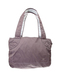

In [ ]:
test_img = '/content/Fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

In [ ]:
#hide-output
import os

styles = pd.read_csv('/content/dataset/styles.csv', on_bad_lines='skip')
styles['id'] = styles['id'].astype('str')
root_path = os.getcwd()
styles.to_csv(root_path+'/styles.csv', index=False)

In [ ]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [ ]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 1280  # Changed from 256 to 1280
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [ ]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

5000it [00:23, 215.30it/s]


In [ ]:
#hide-output
t.build(trees)
t.save('t.ann')

True

In [ ]:
#hide
file_path = '/content/ImgSim/'

In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs(file_path, exist_ok=True)

t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

In [ ]:
#hide
from PIL import Image
import matplotlib.image as mpimg

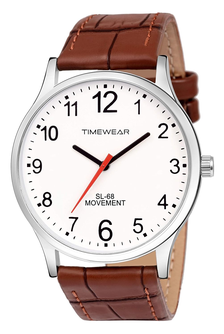

In [ ]:
img_addr = 'https://images-na.ssl-images-amazon.com/images/I/81%2Bd6eSA0eL._UL1500_.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.Resampling.LANCZOS)
img

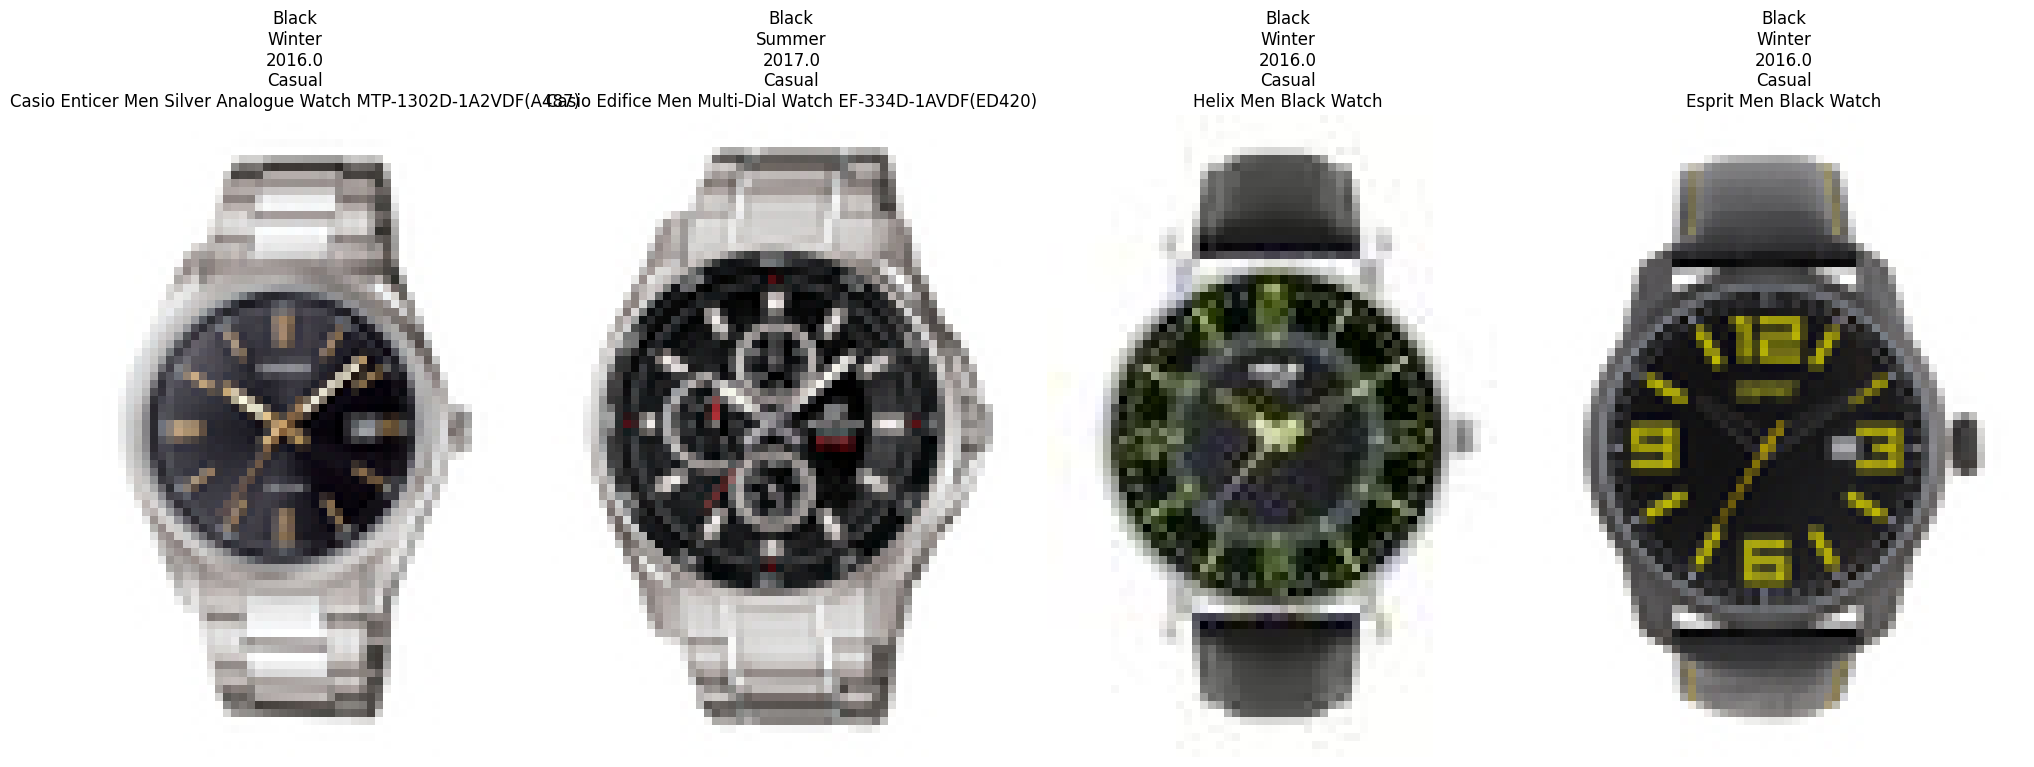

In [ ]:
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()